In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=169649aad97ba9e7b72b51d8398de969560569283ecaf70561687081f553d3cc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

# Initialize SparkContext
sc = SparkContext("local", "Read CSV")


Reading CSV File directly as DataFrame using SQLCOntext

In [3]:
# Initialize SQLContext - directly read the csv as DataFrame
sqlContext = SQLContext(sc)

# Path to your CSV file
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/BigData/dataFIFA.csv"

# Read the CSV file into a DataFrame
df = sqlContext.read.format("csv").option("header", "true").load(csv_file_path)

# Print the first 10 rows
df.show(10)

# Show statistics
df.describe().show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+---+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+-------+-----+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------------+
|_c0|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Log

In [4]:
from pyspark.sql.functions import col, count, when

# Define a function to count missing values per column
def count_missing_values(df):
    # Aggregate the counts of null values per column
    exprs = [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
    if not exprs or exprs is None:
        exprs = ['all good']


    missing_values = df.agg(*exprs)
    return missing_values

# Count missing values
missing_values_df = count_missing_values(df)

# Show the counts of missing values per column
missing_values_df.show()

+---+---+----+---+-----+-----------+----+-------+---------+----+---------+-----+----+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------------+
|_c0| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|Value|Wage|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contra

In [5]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: string (nullable = true)
 |-- Potential: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: string (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: string (nullable = true)
 |-- Weak Foot: string (nullable = true)
 |-- Skill Moves: string (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: string (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = t

# Keeping only interesing features

In [6]:
# List of columns
numerical_columns = ['Age','Overall','Potential','International Reputation']
currency_columns = ['Value', 'Wage','Release Clause']
height_weight_columns = ['Height', 'Weight']


keep_columns = []
keep_columns.extend(numerical_columns)
keep_columns.extend(currency_columns)
keep_columns.extend(height_weight_columns)

# Additional categorical columns
keep_columns.append('Preferred Foot')
keep_columns.append('Club')

df = df.select(*keep_columns)
df.show(5)

+---+-------+---------+------------------------+-------+-----+--------------+------+------+--------------+-------------------+
|Age|Overall|Potential|International Reputation|  Value| Wage|Release Clause|Height|Weight|Preferred Foot|               Club|
+---+-------+---------+------------------------+-------+-----+--------------+------+------+--------------+-------------------+
| 31|     94|       94|                       5|€110.5M|€565K|       €226.5M|   5'7|159lbs|          Left|       FC Barcelona|
| 33|     94|       94|                       5|   €77M|€405K|       €127.1M|   6'2|183lbs|         Right|           Juventus|
| 26|     92|       93|                       5|€118.5M|€290K|       €228.1M|   5'9|150lbs|         Right|Paris Saint-Germain|
| 27|     91|       93|                       4|   €72M|€260K|       €138.6M|   6'4|168lbs|         Right|  Manchester United|
| 27|     91|       92|                       4|  €102M|€355K|       €196.4M|  5'11|154lbs|         Right|    M

# Casting Relevant Numerical features to integers

In [7]:
# Casting valid numerical features
#from pyspark.sql.functions import  regexp_replace, col, count, when # Import col function
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import re

# Cast numerical columns to IntegerType
for column_name in numerical_columns:
    df = df.withColumn(column_name, col(column_name).cast("integer"))


In [8]:
# Define the Conversion function for currency
def convert_currency(value):
    if value is None:
        return None
    if 'M' in value:
        return float(re.sub(r'[€M]', '', value)) * 1000000
    elif 'K' in value:
        return float(re.sub(r'[€K]', '', value)) * 1000
    else:
        return float(re.sub(r'€', '', value))

# Define the Conversion function for units of messurments
def convert_Height_Weight(value):
    if value is None:
        return None
    if '\'' in value:
      match = re.match(r"(\d+)'(\d+)", value)
      if not match:
        return None
      feet = int(match.group(1))
      inches = int(match.group(2))
      return (feet * 30.48) + (inches * 2.54) # to centimeter
    elif 'lbs' in value:
        return float(re.sub('lbs', '', value)) * 0.453592 # to killogram
    else:
        return None





In [9]:
# Register the UDF
convert_currency_udf = udf(convert_currency, FloatType())
convert_hight_weight_udf = udf(convert_Height_Weight, FloatType())

# Apply the UDF to each currency column
for column_name in currency_columns:
    df = df.withColumn(column_name, convert_currency_udf(col(column_name)))

for column_name in height_weight_columns:
    df = df.withColumn(column_name, convert_hight_weight_udf(col(column_name)))


# Show the updated DataFrame with correct data types
df.show(5)
df.select('Wage').show(5)

+---+-------+---------+------------------------+-------+--------+--------------+------+---------+--------------+-------------------+
|Age|Overall|Potential|International Reputation|  Value|    Wage|Release Clause|Height|   Weight|Preferred Foot|               Club|
+---+-------+---------+------------------------+-------+--------+--------------+------+---------+--------------+-------------------+
| 31|     94|       94|                       5|1.105E8|565000.0|       2.265E8|170.18|72.121124|          Left|       FC Barcelona|
| 33|     94|       94|                       5|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|         Right|           Juventus|
| 26|     92|       93|                       5|1.185E8|290000.0|       2.281E8|175.26|  68.0388|         Right|Paris Saint-Germain|
| 27|     91|       93|                       4|  7.2E7|260000.0|       1.386E8|193.04| 76.20345|         Right|  Manchester United|
| 27|     91|       92|                       4| 1.02E8|355000.0|    

#Checking For missing Values in DF

In [10]:
# Count missing values
missing_values_df = count_missing_values(df)

# Show the counts of missing values per column
missing_values_df.show()

+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+
|Age|Overall|Potential|International Reputation|Value|Wage|Release Clause|Height|Weight|Preferred Foot|Club|
+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+
|  0|      0|        0|                      48|    0|   0|          1564|    48|    48|            48| 241|
+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+



In [11]:
# df = df.dropna(how = 'any')
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Value: float (nullable = true)
 |-- Wage: float (nullable = true)
 |-- Release Clause: float (nullable = true)
 |-- Height: float (nullable = true)
 |-- Weight: float (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- Club: string (nullable = true)



In [12]:
from pyspark.sql.functions import mean, col

# List of your numerical columns
numerical_columns_missing = ['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Release Clause', 'Height', 'Weight','International Reputation']

# Replace missing values in each numerical column with the mean of that column
for column in numerical_columns_missing:
    mean_value = df.select(mean(col(column))).collect()[0][0]
    df = df.na.fill({column: mean_value})  # Replace missing values with the mean

# Remove vector rows that have missing values
#hashed_df = hashed_df.dropna()

In [13]:
# Count missing values
missing_values_df = count_missing_values(df)

# Show the counts of missing values per column
missing_values_df.show()

+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+
|Age|Overall|Potential|International Reputation|Value|Wage|Release Clause|Height|Weight|Preferred Foot|Club|
+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+
|  0|      0|        0|                       0|    0|   0|             0|     0|     0|            48| 241|
+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+



In [14]:
df = df.dropna(how = 'any')

In [15]:
# Count missing values
missing_values_df = count_missing_values(df)

# Show the counts of missing values per column
missing_values_df.show()

+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+
|Age|Overall|Potential|International Reputation|Value|Wage|Release Clause|Height|Weight|Preferred Foot|Club|
+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+
|  0|      0|        0|                       0|    0|   0|             0|     0|     0|             0|   0|
+---+-------+---------+------------------------+-----+----+--------------+------+------+--------------+----+



# OneHot Encodding For preferred Foot - Categorical feature

In [16]:
# Determine values for nulls in a pseodo-random fashion for Preferred Foot
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

binary_columns = ['Preferred Foot'] #onehot
categorical_columns = ['Club'] #word2Vec

df = df.withColumn("Preferred Foot",
                   when(col("Preferred Foot").isNull(),
                        when((col("Age") % 2) == 0, "Left").otherwise("Right"))
                   .otherwise(col("Preferred Foot")))


# Convert 'Preferred Foot' into numeric categories
indexer = StringIndexer(inputCol="Preferred Foot", outputCol="Preferred Foot Numeric")
df = indexer.fit(df).transform(df)


# Apply one-hot encoding
encoder = OneHotEncoder(inputCols=["Preferred Foot Numeric"], outputCols=["Preferred Foot Vector"])
df = encoder.fit(df).transform(df)

# Show some of the processed data
df.select("Preferred Foot", "Preferred Foot Numeric", "Preferred Foot Vector").show()


+--------------+----------------------+---------------------+
|Preferred Foot|Preferred Foot Numeric|Preferred Foot Vector|
+--------------+----------------------+---------------------+
|          Left|                   1.0|            (1,[],[])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|         Right|                   0.0|        (1,[0],[1.0])|
|       

In [17]:
df.select('Club').distinct().count()

651

# Club feature has many distinctive categories, hence we will encode them using Hashing feature

In [18]:
# Feature Hasher for categorical feature 'Club' with many distinct values
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="Club", outputCol="Club_Tokens")
df = tokenizer.transform(df)



In [19]:
hashingTF = HashingTF(inputCol="Club_Tokens", outputCol="Club_Hashed", numFeatures=60)  # Select an appropriate number of features
hashed_df = hashingTF.transform(df)

In [20]:
hashed_df.select('Preferred Foot Vector').show(5)
hashed_df.select('Club_Hashed').show(5)
hashed_df.select('Height').show(5)
hashed_df.select('Weight').show(5)

+---------------------+
|Preferred Foot Vector|
+---------------------+
|            (1,[],[])|
|        (1,[0],[1.0])|
|        (1,[0],[1.0])|
|        (1,[0],[1.0])|
|        (1,[0],[1.0])|
+---------------------+
only showing top 5 rows

+--------------------+
|         Club_Hashed|
+--------------------+
|(60,[52,57],[1.0,...|
|     (60,[16],[1.0])|
|(60,[6,19],[1.0,1...|
|(60,[3,17],[1.0,1...|
|(60,[17,55],[1.0,...|
+--------------------+
only showing top 5 rows

+------+
|Height|
+------+
|170.18|
|187.96|
|175.26|
|193.04|
|180.34|
+------+
only showing top 5 rows

+---------+
|   Weight|
+---------+
|72.121124|
| 83.00734|
|  68.0388|
| 76.20345|
|69.853165|
+---------+
only showing top 5 rows



# Creating a data set and a feature column from all the transformed features

In [21]:
hashed_df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Value: float (nullable = false)
 |-- Wage: float (nullable = false)
 |-- Release Clause: float (nullable = false)
 |-- Height: float (nullable = false)
 |-- Weight: float (nullable = false)
 |-- Preferred Foot: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- Preferred Foot Numeric: double (nullable = false)
 |-- Preferred Foot Vector: vector (nullable = true)
 |-- Club_Tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Club_Hashed: vector (nullable = true)



In [22]:
data_columns = []
data_columns.extend(numerical_columns)
data_columns.append('Preferred Foot Vector')
data_columns.extend(currency_columns)
data_columns.extend(height_weight_columns)
data_columns.append('Club_Hashed')
 #['Age', 'Club_Hashed', 'Height', 'Weight', 'Overall', 'Potential', 'International Reputation', 'Value', 'Wage', 'Release Clause', 'Preferred Foot Vector']
dataset = hashed_df.select(*data_columns)
dataset.show(5)

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|
| 26|     92|       93|                       5|        (1,[0],[1.0])|1.185E8|290000.0|       2.281E8|175.26|  68.0388|(60,[6,19],[1.0,1...|
| 27|     91|       93|                       4|        (1,[0],[1.0])|  7.2E7|260000.0|       1.386E8|193.04| 76.20345|(60,[3,17],[1.0,1...|
| 27|     91|

In [23]:
dataset.describe().show()

+-------+------------------+-----------------+-----------------+------------------------+------------------+-----------------+--------------------+------------------+-----------------+
|summary|               Age|          Overall|        Potential|International Reputation|             Value|             Wage|      Release Clause|            Height|           Weight|
+-------+------------------+-----------------+-----------------+------------------------+------------------+-----------------+--------------------+------------------+-----------------+
|  count|             17918|            17918|            17918|                   17918|             17918|            17918|               17918|             17918|            17918|
|   mean|25.105257283178926|66.23680098225249| 71.3293336309856|      1.1139078022100681|2448628.7532090633|9883.748186181494|   4585060.987554414|181.25702543244827|75.28214594311633|
| stddev|   4.6753715836753|6.929243384157863|6.144097650621002|      0.395

In [24]:
dataset.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Preferred Foot Vector: vector (nullable = true)
 |-- Value: float (nullable = false)
 |-- Wage: float (nullable = false)
 |-- Release Clause: float (nullable = false)
 |-- Height: float (nullable = false)
 |-- Weight: float (nullable = false)
 |-- Club_Hashed: vector (nullable = true)



# Creating assembeled column for clustering

In [25]:
from pyspark.ml.feature import VectorAssembler

# Create the VectorAssembler
#data_columns.remove('Wage')
assembler = VectorAssembler(inputCols=data_columns, outputCol="features",handleInvalid="skip")

# Transform the data to have the features column
dataset_assembled = assembler.transform(dataset)
dataset_assembled.show(5)


+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|            features|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|(70,[0,1,2,3,5,6,...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|(70,[0,1,2,3,4,5,...|
| 26|     92|       93|                       5|        (1,[0],[1.0])|1.185E8|290000.0|       2.281E8|175.26|  68.0388|(60,[6,19],[1.0,1...|(70,[0,1,2,3,4,5,...|
| 27|     91|       93|     

In [26]:
dataset_assembled.select('features').first()


Row(features=SparseVector(70, {0: 31.0, 1: 94.0, 2: 94.0, 3: 5.0, 5: 110500000.0, 6: 565000.0, 7: 226500000.0, 8: 170.18, 9: 72.1211, 62: 1.0, 67: 1.0}))

In [27]:
dataset_assembled.show(truncate=False)

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|Value  |Wage    |Release Clause|Height|Weight   |Club_Hashed                 |features                                                                                                                           |
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|31 |94     |94       |5                       |(1,[],[])            |1.105E8|565000.0|2.265E8       |170.18|72.121124|(60,[52,57],[1.0,1.0])      |(70,[0,1,

In [28]:
# This part is due to an error with UDF i had
dataset_assembled.cache()  # Cache the DataFrame
dataset_assembled.count() # Trigger an action to populate the cache

17918

In [29]:
#print(dataset_assembled.explain())

# Now Dataset contains 10 features for model training.

I'll use KMeans clustering model to seperate the dataset to clusters and silhoutte score in order to identify the best seperation.

In [30]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors

In [31]:
score = []
amount = []
def clusteringData(df, score, amount):
  #score = score
  #amount = []
  clusters = 30
  for cluster in range(2, clusters):
      kmeans = KMeans().setK(cluster).setSeed(1234)
      model = kmeans.fit(df)
          # Make predictions
      predictions = model.transform(df)
          # Evaluate clustering by computing Silhouette score
      evaluator = ClusteringEvaluator()

      silhouette = evaluator.evaluate(predictions)
      score.append(silhouette)
      amount.append(cluster)
      print(cluster, " Silhouette with squared euclidean distance = " + str(silhouette))

clusteringData(dataset_assembled,score,amount)

2  Silhouette with squared euclidean distance = 0.9639989123280025
3  Silhouette with squared euclidean distance = 0.9169613193107534
4  Silhouette with squared euclidean distance = 0.9081343300290974
5  Silhouette with squared euclidean distance = 0.8966782743452083
6  Silhouette with squared euclidean distance = 0.8612658669061759
7  Silhouette with squared euclidean distance = 0.7970022454743415
8  Silhouette with squared euclidean distance = 0.8021856403990195
9  Silhouette with squared euclidean distance = 0.8068492391867879
10  Silhouette with squared euclidean distance = 0.8100583333958316
11  Silhouette with squared euclidean distance = 0.8012268685347028
12  Silhouette with squared euclidean distance = 0.8057518644394658
13  Silhouette with squared euclidean distance = 0.8054154866901616
14  Silhouette with squared euclidean distance = 0.8022990107509135
15  Silhouette with squared euclidean distance = 0.8099809934226303
16  Silhouette with squared euclidean distance = 0.78365

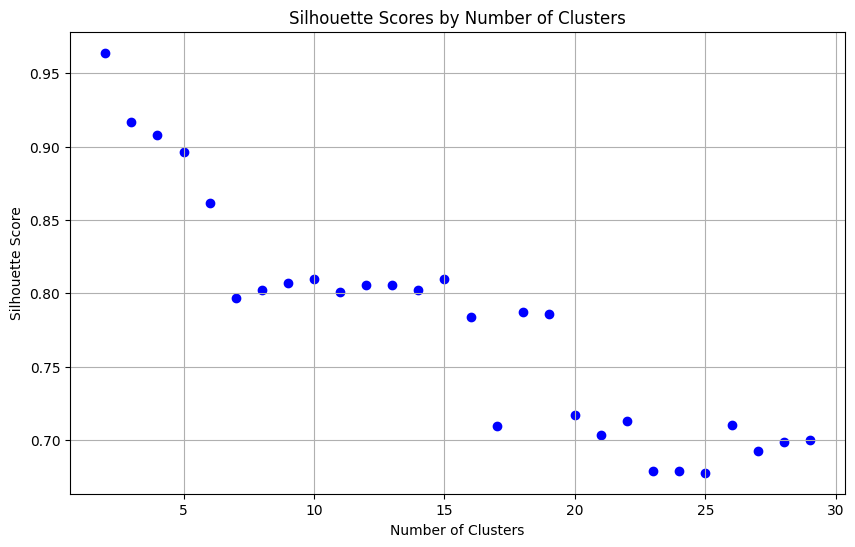

In [33]:
# Create a scatter plot
import matplotlib.pyplot as plt

def plot_silhouette(score, amount):
  plt.figure(figsize=(10, 6))
  plt.scatter(amount, score, color='blue')
  plt.title('Silhouette Scores by Number of Clusters')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.grid(True)
  plt.show()

plot_silhouette(score, amount)

# Conclusion - 2,3,4,5,6 is the best clusters.

For the best clusters, we will check how many players with highest salary belong to same cluster.

In [34]:
top_players = dataset_assembled.orderBy(col("Wage").desc()).limit(10)
top_players.show()

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|            features|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|(70,[0,1,2,3,5,6,...|
| 31|     91|       91|                       5|        (1,[0],[1.0])|  8.0E7|455000.0|        1.64E8|182.88| 86.18248|(60,[52,57],[1.0,...|(70,[0,1,2,3,4,5,...|
| 32|     91|       91|                       4|        (1,[0],[1.0])|  6.7E7|420000.0|       1.374E8|172.72|66.224434|(60,[37,51],[1.0,...|(70,[0,1,2,3,4,5,...|
| 33|     94|       94|     

In [38]:
# List of best cluster
best_clusters = [2, 3, 4, 5, 6]
dataset_assembled_withClusters = dataset_assembled.select('*')
dataset_assembled_withClusters.show(5)

for k in best_clusters:
    # Initialize KMeans
    kmeans = KMeans().setK(k).setSeed(1234)
    model = kmeans.fit(dataset_assembled_withClusters)

    # Transform the dataset to include cluster labels
    predictions = model.transform(dataset_assembled_withClusters)

    # Add cluster labels as a new column
    cluster_col_name = f"cluster_{k}"
    dataset_assembled_withClusters = predictions.withColumnRenamed("prediction", cluster_col_name)


+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|            features|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|(70,[0,1,2,3,5,6,...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|(70,[0,1,2,3,4,5,...|
| 26|     92|       93|                       5|        (1,[0],[1.0])|1.185E8|290000.0|       2.281E8|175.26|  68.0388|(60,[6,19],[1.0,1...|(70,[0,1,2,3,4,5,...|
| 27|     91|       93|     

In [39]:
top_players = dataset_assembled_withClusters.orderBy(col("Wage").desc()).limit(10)
top_players.show()

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+---------+---------+---------+---------+---------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|            features|cluster_2|cluster_3|cluster_4|cluster_5|cluster_6|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+---------+---------+---------+---------+---------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|(70,[0,1,2,3,5,6,...|        1|        2|        2|        4|        1|
| 31|     91|       91|                       5|        (1,[0],[1.0])|  8.0E7|455000.0|        1.64E8|182.88| 86.18248|(60,[52,57],[1.0,...|(70,[0,1,2,3

In [40]:
top_players.groupBy("cluster_2").count().show()
top_players.groupBy("cluster_3").count().show()
top_players.groupBy("cluster_4").count().show()
top_players.groupBy("cluster_5").count().show()
top_players.groupBy("cluster_6").count().show()

+---------+-----+
|cluster_2|count|
+---------+-----+
|        1|   10|
+---------+-----+

+---------+-----+
|cluster_3|count|
+---------+-----+
|        2|   10|
+---------+-----+

+---------+-----+
|cluster_4|count|
+---------+-----+
|        2|   10|
+---------+-----+

+---------+-----+
|cluster_5|count|
+---------+-----+
|        4|    9|
|        1|    1|
+---------+-----+

+---------+-----+
|cluster_6|count|
+---------+-----+
|        1|   10|
+---------+-----+



# PCA - reducing dimentions

In [41]:
dataset_assembled_withClusters.show()

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+---------+---------+---------+---------+---------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|            features|cluster_2|cluster_3|cluster_4|cluster_5|cluster_6|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+---------+---------+---------+---------+---------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|(70,[0,1,2,3,5,6,...|        1|        2|        2|        4|        1|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|(70,[0,1,2,3

In [42]:
from pyspark.ml.feature import PCA # 10 -> 5

pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")

# Fit PCA model to the data
model = pca.fit(dataset_assembled)

# Transform the data according to the PCA model
result = model.transform(dataset_assembled)

# Show the resulting features
#result.select("pcaFeatures").show(truncate=False)
print("Explained Variance (5 components):", model.explainedVariance)
result.show(5)

Explained Variance (5 components): [0.9910276897496547,0.00897142988553157,8.803636378071059e-07,5.804049012335315e-13,2.758173473363698e-13]
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|            features|         pcaFeatures|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|(70,[0,1,2,3,5,6,...|[-2.5194677647485...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (6

In [45]:
result = result.drop('features')
result.show(5)

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|         pcaFeatures|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|[-2.5194677647485...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|[-1.4827070090967...|
| 26|     92|       93|                       5|        (1,[0],[1.0])|1.185E8|290000.0|       2.281E8|175.26|  68.0388|(60,[6,19],[1.0,1...|[-2.5704429789014...|
| 27|     91|       93|     

In [46]:
assembler = VectorAssembler(inputCols=['pcaFeatures'], outputCol="features",handleInvalid="skip")
# Transform the data to have the features column
pca_dataset = assembler.transform(result)
pca_dataset.show(5)
pca_dataset.cache()  # Cache the DataFrame
pca_dataset.count()

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|         pcaFeatures|            features|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|[-2.5194677647485...|[-2.5194677647485...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|[-1.4827070090967...|[-1.4827070090967...|
| 26|     92|       93|                       5|        (1,[0],[1.0])|1.185E8|290000.

17918

Checking the quality of KMeans cluster if used with PCA encoded features as input

In [47]:
score = []
amount = []

clusteringData(pca_dataset,score,amount)

2  Silhouette with squared euclidean distance = 0.9639989123280216
3  Silhouette with squared euclidean distance = 0.916961319310875
4  Silhouette with squared euclidean distance = 0.9081343300293355
5  Silhouette with squared euclidean distance = 0.8966782743455604
6  Silhouette with squared euclidean distance = 0.8612658669068903
7  Silhouette with squared euclidean distance = 0.7970022454763978
8  Silhouette with squared euclidean distance = 0.8021856404034406
9  Silhouette with squared euclidean distance = 0.8068492391892229
10  Silhouette with squared euclidean distance = 0.8100583334006121
11  Silhouette with squared euclidean distance = 0.8012268685403994
12  Silhouette with squared euclidean distance = 0.8057518644447899
13  Silhouette with squared euclidean distance = 0.8054154866954285
14  Silhouette with squared euclidean distance = 0.8022990107566443
15  Silhouette with squared euclidean distance = 0.8099809934283096
16  Silhouette with squared euclidean distance = 0.783653

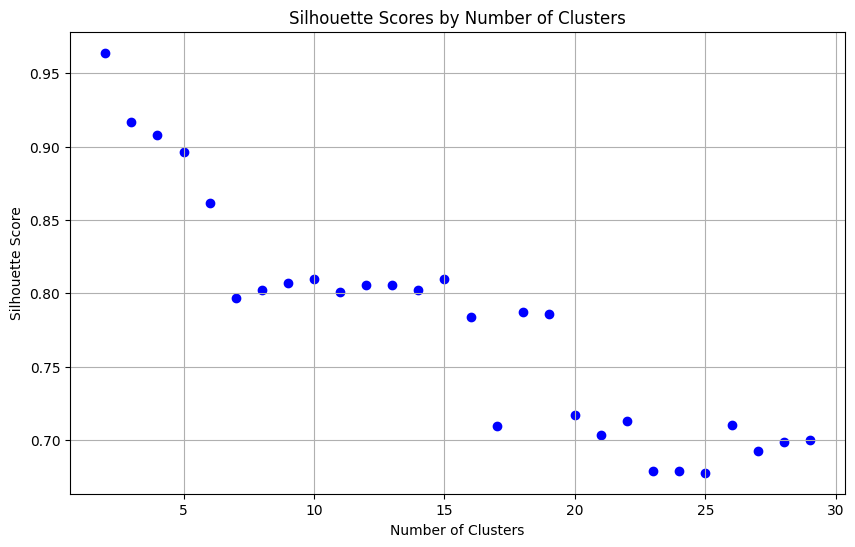

In [48]:
plot_silhouette(score, amount)


# PCA with 2 features
 While using the PCA features that were incoded for 5 dimensions, inorder to reduce the data to 2 features.

In [49]:
pca = PCA(k=2, inputCol="pcaFeatures", outputCol="pcaFeatures_2")

# Fit PCA model to the data
model = pca.fit(result)

# Transform the data according to the PCA model
result = model.transform(result)

# Show the resulting features
#result.select("pcaFeatures").show(truncate=False)
print("Explained Variance (2 components):", model.explainedVariance)
result.show(5)

Explained Variance (2 components): [0.991027689749883,0.008971429885623054]
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|         pcaFeatures|       pcaFeatures_2|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|[-2.5194677647485...|[2.51946776474856...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|[-1.4827070090967...|[1.48270700909671...|
| 26|    

In [50]:
assembler = VectorAssembler(inputCols=['pcaFeatures_2'], outputCol="features",handleInvalid="skip")
# Transform the data to have the features column
pca_dataset = assembler.transform(result)
pca_dataset.show(5)
pca_dataset.cache()  # Cache the DataFrame
pca_dataset.count()

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+--------------------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|         pcaFeatures|       pcaFeatures_2|            features|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+--------------------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|[-2.5194677647485...|[2.51946776474856...|[2.51946776474856...|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|[-1.4827070090967...|[1.48270700909671...|[1

17918

In [51]:
score = []
amount = []
clusteringData(pca_dataset,score,amount)

2  Silhouette with squared euclidean distance = 0.9639989527338202
3  Silhouette with squared euclidean distance = 0.9169615374564769
4  Silhouette with squared euclidean distance = 0.9081346952735504
5  Silhouette with squared euclidean distance = 0.8966787732512519
6  Silhouette with squared euclidean distance = 0.8612666596595405
7  Silhouette with squared euclidean distance = 0.7970041263303365
8  Silhouette with squared euclidean distance = 0.8021882615001242
9  Silhouette with squared euclidean distance = 0.8068513454025008
10  Silhouette with squared euclidean distance = 0.8053266074681564
11  Silhouette with squared euclidean distance = 0.8012305693683072
12  Silhouette with squared euclidean distance = 0.8057554847882265
13  Silhouette with squared euclidean distance = 0.8054189274803214
14  Silhouette with squared euclidean distance = 0.8023030923618415
15  Silhouette with squared euclidean distance = 0.8099851927522184
16  Silhouette with squared euclidean distance = 0.78365

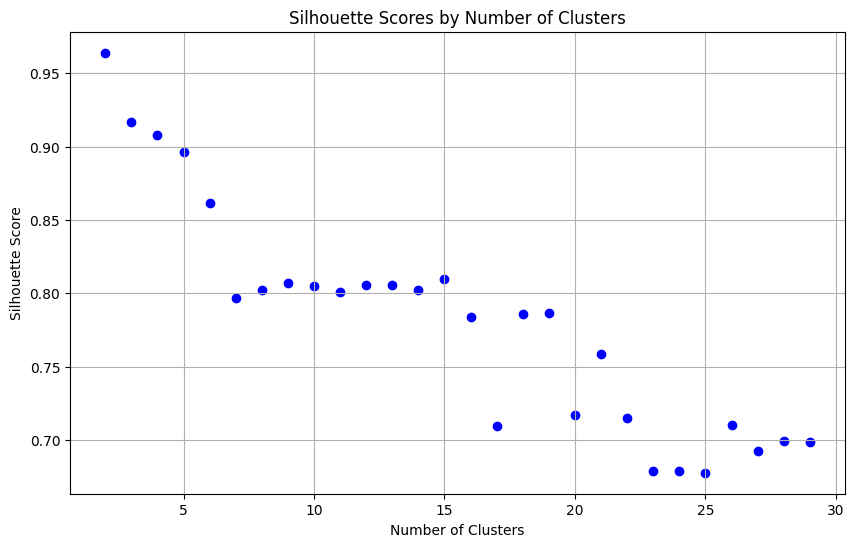

In [52]:
plot_silhouette(score, amount)

In [53]:
kmeans = KMeans().setK(5).setSeed(1234)
model = kmeans.fit(pca_dataset)

# Transform the dataset to include cluster labels
predictions = model.transform(pca_dataset)

# Add cluster labels as a new column
cluster_col_name = f"cluster_{5}"
dataset_assembled2 = predictions.withColumnRenamed("prediction", cluster_col_name)

In [54]:
dataset_assembled2.show()

+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+--------------------+---------+
|Age|Overall|Potential|International Reputation|Preferred Foot Vector|  Value|    Wage|Release Clause|Height|   Weight|         Club_Hashed|         pcaFeatures|       pcaFeatures_2|            features|cluster_5|
+---+-------+---------+------------------------+---------------------+-------+--------+--------------+------+---------+--------------------+--------------------+--------------------+--------------------+---------+
| 31|     94|       94|                       5|            (1,[],[])|1.105E8|565000.0|       2.265E8|170.18|72.121124|(60,[52,57],[1.0,...|[-2.5194677647485...|[2.51946776474856...|[2.51946776474856...|        4|
| 33|     94|       94|                       5|        (1,[0],[1.0])|  7.7E7|405000.0|       1.271E8|187.96| 83.00734|     (60,[16],[1.0])|[-1.

In [55]:
pandas_df = dataset_assembled2.select("features", "cluster_5", "Wage").toPandas()

In [56]:
pandas_df['PCA1'] = pandas_df['features'].apply(lambda x: x[0])
pandas_df['PCA2'] = pandas_df['features'].apply(lambda x: x[1])

top_10_players = pandas_df.sort_values(by='Wage', ascending=False).head(10)

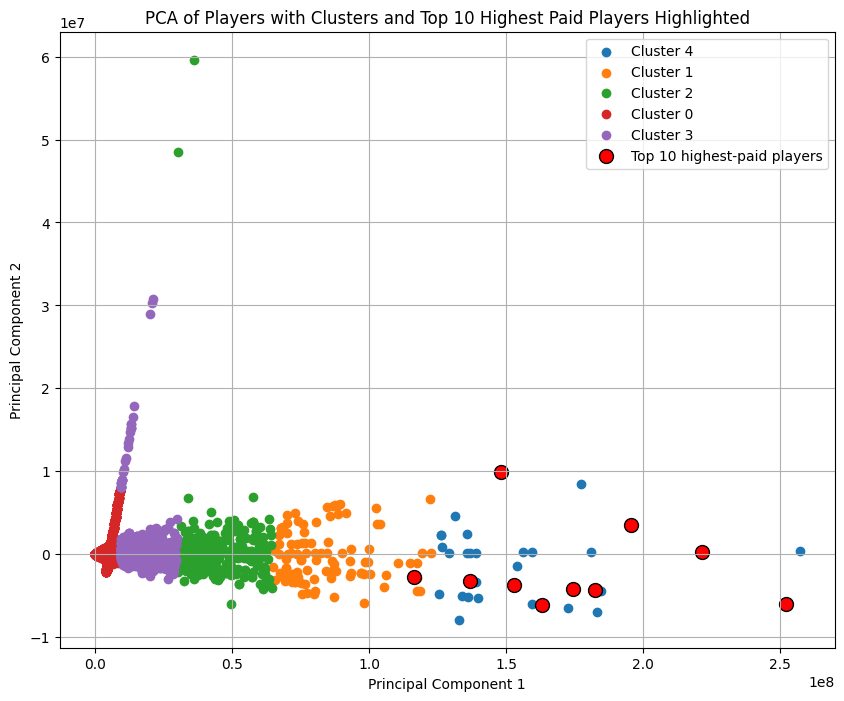

In [57]:
plt.figure(figsize=(10, 8))
for cluster in pandas_df['cluster_5'].unique():
    # Plot each cluster
    cluster_data = pandas_df[pandas_df['cluster_5'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

# Highlight the top 10 highest-paid players
plt.scatter(top_10_players['PCA1'], top_10_players['PCA2'], color='red', label='Top 10 highest-paid players', edgecolors='black', s=100)

plt.title('PCA of Players with Clusters and Top 10 Highest Paid Players Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

5 Clusters were chosen to see the difference in clusters and that one player from highest wage can be found in diffrent cluster